### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv('Transactions.csv')
df

,trans_ID,tr_date,item_description,quantity_out,total_amt,Sheet1.billto_tin
0,1c3dec63-5d6a-4aaa-a47d-f515180cac91,7/6/2023,laundry plastic,1,297.99,31389315.0
1,273e062f-29dc-48c4-b389-213433718e04,7/6/2023,Romoli balsamico vingar 500ml,1,1078.99,31389315.0
2,273e062f-29dc-48c4-b389-213433718e04,7/6/2023,bakerd brown sugar sticks,1,384.99,31389315.0
3,273e062f-29dc-48c4-b389-213433718e04,7/6/2023,coconut milk,1,279.00,31389315.0
4,273e062f-29dc-48c4-b389-213433718e04,7/6/2023,kellerbery corn flakes 500gm,1,490.00,31389315.0
...,...,...,...,...,...,...
8483,003-02-0000000002,3/16/2017,Elsa kolo,1,89.00,1278679.0
8484,003-02-0000000002,3/16/2017,Nido powder milk 900gm**12,1,329.00,1278679.0
8485,002-01-0000000001,3/13/2017,orange,1,45.00,NaN
8486,003-02-0000000001,3/13/2017,locla egg,1,4.00,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8488 entries, 0 to 8487
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   trans_ID           8488 non-null   object 
 1   tr_date            8488 non-null   object 
 2   item_description   8488 non-null   object 
 3   quantity_out       8488 non-null   int64  
 4   total_amt          8488 non-null   float64
 5   Sheet1.billto_tin  7196 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 398.0+ KB


In [4]:
df.head()

,trans_ID,tr_date,item_description,quantity_out,total_amt,Sheet1.billto_tin
0,1c3dec63-5d6a-4aaa-a47d-f515180cac91,7/6/2023,laundry plastic,1,297.99,31389315.0
1,273e062f-29dc-48c4-b389-213433718e04,7/6/2023,Romoli balsamico vingar 500ml,1,1078.99,31389315.0
2,273e062f-29dc-48c4-b389-213433718e04,7/6/2023,bakerd brown sugar sticks,1,384.99,31389315.0
3,273e062f-29dc-48c4-b389-213433718e04,7/6/2023,coconut milk,1,279.00,31389315.0
4,273e062f-29dc-48c4-b389-213433718e04,7/6/2023,kellerbery corn flakes 500gm,1,490.00,31389315.0


### Trying to Find Out Each Customer's Recency, Frequency, and Monetary Values

In [5]:
# RECENCY

day = "2023-07-06"
day = pd.to_datetime(day)
df['tr_date'] = pd.to_datetime(df["tr_date"])



recency=df.groupby(["Sheet1.billto_tin"]).agg({"tr_date":lambda x:((day-x.max()).days)})

In [6]:
recency

,tr_date
Sheet1.billto_tin,
6953.0,10
7181.0,974
11277.0,1142
12879.0,342
14115.0,1011
...,...
51046817.0,1013
51432520.0,262
51967525.0,199


In [7]:
# FREQUENCY

freq=df.drop_duplicates(subset="trans_ID").groupby(["Sheet1.billto_tin"])[["trans_ID"]].count()
freq.head(5)

,trans_ID
Sheet1.billto_tin,
6953.0,223
7181.0,1
11277.0,7
12879.0,1
14115.0,1


In [8]:
# MONETARY

df["total"] = df["quantity_out"] * df["total_amt"]

In [9]:
money = df.groupby(["Sheet1.billto_tin"])[["total"]].sum()
money.head()

,total
Sheet1.billto_tin,
6953.0,5341658.22
7181.0,770299.77
11277.0,2935.27
12879.0,2759.48
14115.0,35487.21


In [19]:
#Adding the calculated RFM columns

RFM = pd.concat([recency,freq,money], axis=1)
recency.columns = ["Recency"]
freq.columns = ["Frequency"]
money.columns = ["Monetary"]
RFM.head(15)

,Recency,Frequency,Monetary
Sheet1.billto_tin,,,
6953.0,10,223,5341658.22
7181.0,974,1,770299.77
11277.0,1142,7,2935.27
12879.0,342,1,2759.48
14115.0,1011,1,35487.21
26865.0,1777,3,616108.99
30473.0,399,4,7248.70
32874.0,517,1,39763.00
38326.0,2138,2,15368.77


### Implementing the K-Means Model

In [11]:
#Transforming the data frame to a more appropriate format 

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled = scaler.fit_transform(RFM)

C:\Users\Blen\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Blen\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Blen\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Blen\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are les

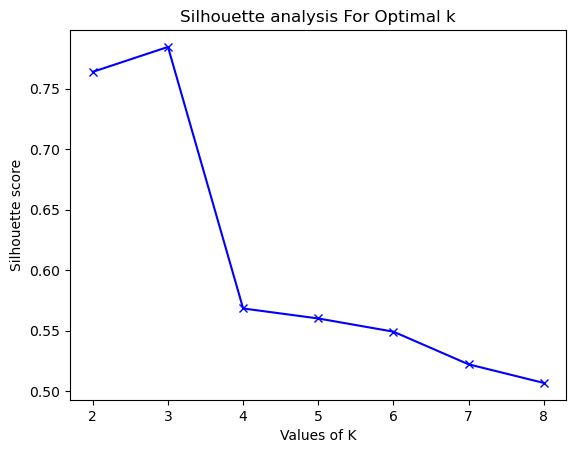

In [12]:
#Calculating the best K using Silhouette

range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
silhouette_avg = []
for num_clusters in range_n_clusters:
 
 # initialise kmeans
 kmeans = KMeans(n_clusters = num_clusters)
 kmeans.fit(scaled)
 cluster_labels = kmeans.labels_
 
 # silhouette score
 silhouette_avg.append(silhouette_score(scaled, cluster_labels))
    
plt.plot(range_n_clusters,silhouette_avg,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

In [13]:
#Feeding our data to the kmeans model

kmeans = KMeans(n_clusters=3, n_init = 10)

kmeans.fit(scaled)

RFM["Clusters"] = (kmeans.labels_+1)

C:\Users\Blen\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [14]:
RFM.head(10)

,tr_date,trans_ID,total,Clusters
Sheet1.billto_tin,,,,
6953.0,10,223,5341658.22,3
7181.0,974,1,770299.77,1
11277.0,1142,7,2935.27,1
12879.0,342,1,2759.48,1
14115.0,1011,1,35487.21,1
26865.0,1777,3,616108.99,1
30473.0,399,4,7248.70,1
32874.0,517,1,39763.00,1
38326.0,2138,2,15368.77,1


In [15]:
def func(row):
    if row["Clusters"]==1:
        return 'Low RFM Value'
    elif row["Clusters"]==2:
        return 'In-between'
    else:
        return 'Higher RFM Value'

In [16]:
RFM['Cluster_Value']=RFM.apply(func, axis=1)

RFM.head(10)


,tr_date,trans_ID,total,Clusters,Cluster_Value
Sheet1.billto_tin,,,,,
6953.0,10,223,5341658.22,3,Higher RFM Value
7181.0,974,1,770299.77,1,Low RFM Value
11277.0,1142,7,2935.27,1,Low RFM Value
12879.0,342,1,2759.48,1,Low RFM Value
14115.0,1011,1,35487.21,1,Low RFM Value
26865.0,1777,3,616108.99,1,Low RFM Value
30473.0,399,4,7248.70,1,Low RFM Value
32874.0,517,1,39763.00,1,Low RFM Value
38326.0,2138,2,15368.77,1,Low RFM Value


In [17]:
result = RFM.Cluster_Value.value_counts()
result

Cluster_Value
Low RFM Value       70
Higher RFM Value     2
In-between           2
Name: count, dtype: int64

<Axes: ylabel='Cluster_Value'>

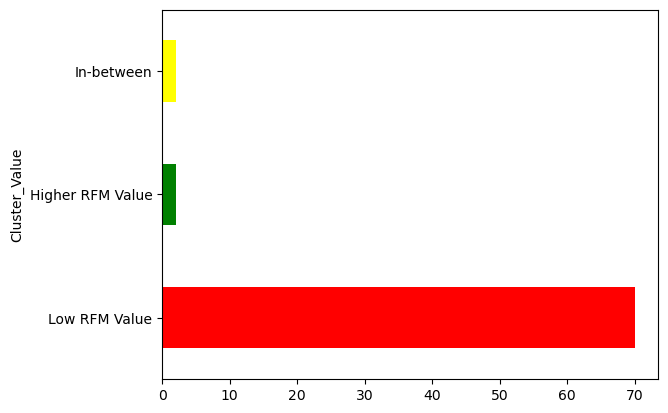

In [18]:
result.plot(kind="barh", color=["Red","Green","Yellow"])